# Your First GAN

### 목표
이 노트북에서는 이 과정을 위한 첫 번째 생성적 적대 신경망(GAN)을 만들 것입니다! 특히, 손으로 쓴 숫자 (0-9) 이미지를 생성 할 수 있는 GAN을 빌드하고 훈련합니다. 이 과제에서 PyTorch를 사용하게 되므로, 이 프레임워크에 익숙하지 않은 경우 [PyTorch documentation](https://pytorch.org/docs/stable/index.html)가 유용 할 수 있습니다. 힌트에는 종종 관련 문서에 대한 링크가 포함됩니다.

### 학습 목표

1. GAN의 생성기 및 판별기 구성 요소를 처음부터 빌드합니다.
2. 생성기 및 판별기 손실 함수를 만듭니다.
3. GAN을 훈련시키고 생성된 이미지를 시각화합니다.

## 시작하기
GAN을 빌드하고 훈련하는 데 사용할 몇 가지 유용한 패키지와 데이터 세트를 가져 오는 것으로 시작합니다. GAN이 생성할 이미지를 조사하는 데 도움이 되는 시각화 도우미 함수도 제공됩니다.

In [139]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    이미지 시각화 함수: 이미지의 텐서, 이미지 수 및 이미지당 크기가 주어지면 
    이미지를 균일한 그리드에 플롯하고 출력합니다.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST 데이터 세트
판별기가 사용할 훈련 이미지는 [MNIST](http://yann.lecun.com/exdb/mnist/)라는 데이터 세트에서 가져온 것입니다. 여기에는 다음과 같이 0부터 9까지 손으로 쓴 숫자의 60,000 개 이미지가 포함됩니다:

![MNIST Digits](MNIST_Progression.png)
 
이미지가 상당히 픽셀화 되어 있음을 알 수 있습니다. 이는 모두 28 x 28에 불과하기 때문입니다! 이미지 크기가 작기 때문에 MNIST는 간단한 교육에 이상적입니다. 또한 이러한 이미지는 흑백으로 표시되므로 이미지를 표현하는 데는 하나의 차원 또는 "색상 채널"만 필요합니다 (이 내용은 나중에 자세히 설명합니다).

#### Tensor
[tensors](https://pytorch.org/docs/stable/tensors.html)를 사용하여 데이터를 나타냅니다. 텐서는 행렬의 일반화입니다. 예를 들어 64 x 64 픽셀 이미지의 서로 다른 위치에 있는 빨강, 녹색 및 파랑의 양을 가진 3 개의 행렬 스택은 3 x 64 x 64 모양의 텐서입니다.

Tensor는 조작하기 쉽고, 사용할 머신러닝 라이브러리 인 [PyTorch](https://pytorch.org/)에서 지원됩니다. 더 자세히 살펴보실 수 있지만,이를 다차원 행렬 또는 벡터로 상상할 수 있습니다!


#### 배치(Batches)
하나의 이미지를 생성 한 후 모델을 훈련시킬 수는 있지만, 매우 비효율적이며 훈련의 안정성이 떨어집니다. GAN 및 일반적으로 기계학습에서 학습 단계 당 여러 이미지를 동시에 처리합니다. 이를 배치(batch)라고 합니다.

즉, 생성기가 전체 이미지 배치를 생성하고, 모델을 업데이트하기 전에 각각에 대한 판별기의 피드백을 받습니다. 판별기에 대해서도 마찬가지입니다. 모델이 업데이트 되기 전에 생성된 이미지의 전체 배치와 실제에 대한 손실을 계산합니다.

## 생성자(Generator)

첫 번째 단계는 생성자 구성 요소를 구축하는 것입니다.

생성자의 신경망을 위한 단일 레이어/블록을 만드는 함수를 만드는 것으로 시작합니다. 각 블록에는 다른 모양에 매핑하기 위한 [선형 변환](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), 안정화를 위한 [배치 정규화](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) , 마지막으로 비선형 활성화 함수 (여기서는 [ReLU](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html) 사용)가 포함되어 출력을 복잡한 방식으로 변환 할 수 있습니다. 과정의 뒷부분에서 활성화 및 배치 정규화에 대해 자세히 알아 봅니다.

In [140]:
def get_generator_block(input_dim, output_dim):
    '''
    입력 및 출력 차원이 지정된 생성기의 신경망 블록을 반환하는 함수입니다.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        선형 변환 후 배치 정규화 및 relu 활성화가 있는 생성기 신경망 층
    '''
    return nn.Sequential(
        # reference ==> https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE (~3 lines)####

        
        
        #### END CODE HERE ####
    )

In [141]:
# Verify the generator block function
def test_gen_block(in_features, out_features, num_test=1000):
    
    block = get_generator_block(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU
    
    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65
    print("Standard Deviation of test :", test_output.std())

test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

Standard Deviation of test : tensor(0.5848, grad_fn=<StdBackward>)
Standard Deviation of test : tensor(0.5865, grad_fn=<StdBackward>)
Success!


이제 생성기 클래스를 빌드 할 수 있습니다. 3 가지 값이 필요합니다.

* 노이즈 벡터 차원
* 이미지 크기
* 숨겨진 초기 차원

이 값을 사용하여 생성기는 5 개의 레이어/블록으로 신경망을 구축합니다. 노이즈 벡터부터 시작하여 생성기는 텐서가 출력 될 이미지의 크기(MNIST의 실제 이미지와 동일한 크기)에 매핑 될 때까지 블록 함수를 통해 비선형 변환을 적용합니다. 최종 레이어는 다른 레이어와 다르기 때문에 코드를 입력해야 합니다. 최종 레이어는 정규화 또는 활성화 함수가 필요하지 않지만 [시그모이드 함수](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html)로 확장해야 합니다.

마지막으로, 노이즈 벡터를 받아 신경망을 사용하여 출력 차원의 이미지를 생성하는 순방향 통과 함수가 제공됩니다.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">Generator</font></code></b>
</font>
</summary>

1. 최종 선형 변환의 출력 크기는 im_dim 이어야 하지만 시그모이드 함수를 사용하여 출력을 0과 1 사이로 스케일링해야 합니다.
2. [nn.Linear(https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and [nn.Sigmoid(https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html) will be useful here. 
</details>


In [142]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE (~2 lines) ####

            
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        생성기의 순방향 전파를 완료하기 위한 함수: 
        노이즈 텐서가 주어지면 생성된 이미지를 반환합니다.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [143]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    assert str(gen.__getitem__(4)).replace(' ', '') == f'Linear(in_features={hidden_dim * 8},out_features={im_dim},bias=True)'
    assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## 잡음

생성기를 사용하려면 노이즈 벡터를 생성 할 수 있어야 합니다. 노이즈 벡터 z는 동일한 클래스에서 생성된 이미지가 모두 똑같이 보이지 않도록 하는 중요한 역할을 합니다. 정규 분포에서 난수를 샘플링하여 PyTorch를 사용하여 무작위로 생성합니다. 패스 당 여러 이미지가 처리되므로 모든 노이즈 벡터를 한 번에 생성합니다.

torch.ones, torch.zeros 또는 torch.randn을 사용하여 새 텐서를 생성 할 때마다 대상 장치 (예 : `torch.ones(3, 3, device=device)` 또는`torch.ones(3, 3).to(device)`를 사용하여 대상 장치로 이동합니다. 다른 텐서를 조작하거나 `torch.ones_like` 와 같이 기기 입력을 기본 설정하는 텐서의 변형을 사용하여 텐서를 만드는 경우에는 이 작업을 수행 할 필요가 없습니다. 일반적으로 가능한 경우 'torch.ones' 또는 'torch.zeros' 대신 'torch.ones_like' 및 'torch.zeros_like'를 사용합니다.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">get_noise</font></code></b>
</font>
</summary>

1. 당신은 아마도 여기서 [torch.randn](https://pytorch.org/docs/master/generated/torch.randn.html) 이 유용하다는 것을 알게 될 것입니다.
</details>

In [144]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    노이즈 벡터 생성 함수: 차원(n_samples, z_dim)이 주어지면 
    정규 분포의 난수로 채워진 차원 모양의 텐서를 생성합니다. 
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE (~1 line) ####
    return 
    #### END CODE HERE ####

In [145]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    
    noise = get_noise(n_samples, z_dim, device)
    
    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## 판별자

구성해야하는 두 번째 구성 요소는 판별기입니다. 생성기 구성 요소와 마찬가지로 판별기를 위한 신경망 블록을 만드는 함수를 만드는 것으로 시작합니다.

*참고 : Leaky ReLU를 사용하여 ReLU에 지속적으로 음의 값이 전달되어, 0 기울기가 발생하여 매개 변수 변경이 중지되는 현상을 나타내는 "ReLU 죽어가는"문제를 방지합니다. 다음 강의에서 이에 대해 자세히 알아볼 것입니다!*


REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](relu-graph.png)  |  ![](lrelu-graph.png)





In [146]:
def get_discriminator_block(input_dim, output_dim):
    '''
    판별기 블록
     주어진 입력 및 출력 차원의 판별기 신경망을 반환하는 함수입니다.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE (~2 lines)####

        
        #### END CODE HERE ####
    )

In [147]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5
    
    assert str(block.__getitem__(0)).replace(' ', '') == f'Linear(in_features={in_features},out_features={out_features},bias=True)'        
    assert str(block.__getitem__(1)).replace(' ', '').replace(',inplace=True', '') == 'LeakyReLU(negative_slope=0.2)'


test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


이제 이러한 블록을 사용하여 판별기를 만들 수 있습니다! 판별기 클래스에는 두 가지 값이 있습니다.

* 이미지 차원
* 은닉층 차원

판별자는 4 개의 레이어로 구성된 신경망을 구축합니다. 이미지 텐서로 시작하여 단일 숫자 (1 차원 텐서) 출력을 반환 할 때까지 변환합니다. 이 출력은 이미지가 가짜인지 실제인지를 분류합니다. 손실 함수에 포함되어 있으므로 출력층 뒤에 시그모이드가 필요하지 않습니다. 마지막으로, 판별기의 신경망을 사용하기 위해 분류 할 이미지 텐서를 가져 오는 순방향 전파 함수가 제공됩니다.

In [148]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE (~1 line) ####

            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        판별자의 순방향 전파를 완료하는 함수: 
        이미지 텐서가 주어지면 가짜/진짜를 나타내는 1차원 텐서를 반환합니다.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [149]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4
    assert type(disc.__getitem__(3)) == nn.Linear

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


## 훈련
이제 모든 것을 합칠 수 있습니다!
먼저 매개 변수를 설정합니다.
   * criterion : 손실 함수
   * n_epochs : 훈련 할 때 전체 데이터 세트를 반복하는 횟수
   * z_dim : 노이즈 벡터의 차원
   * display_step : 이미지를 표시/시각화하는 빈도
   * batch_size : 정방향/역방향 패스 당 이미지 수
   * lr : 학습률
   * device : CPU가 아닌 GPU (CUDA 실행)를 사용하는 장치 유형

다음으로 데이터 로더를 사용하여 MNIST 데이터 세트를 텐서로 로드합니다.

In [150]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 5000
batch_size = 128
lr = 0.00001
device = 'cuda'
# device = 'cpu'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

이제 생성기, 판별기 및 최적화 프로그램을 초기화 할 수 있습니다. 각 옵티마이저가 모델 중 하나만 최적화하기를 원하기 때문에 각 옵티마이저는 특정 모델의 매개 변수만 취합니다.

In [151]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

GAN을 훈련하기 전에 판별자의 손실과 생성자의 손실을 계산하는 함수를 만들어야 합니다. 이것이 판별자와 생성자가 자신이 어떻게 하고 있는지 알고 스스로를 개선하는 방법입니다. 판별자의 손실을 계산할 때 생성자가 필요하므로 판별자만 업데이트되도록 생성자 결과에서 .detach()를 호출해야 합니다!

이전에 손실 함수를 이미 정의했으며 (`criterion`) `torch.ones` 또는`torch.zeros` 대신 `torch.ones_like` 및 `torch.zeros_like`를 사용하는 것이 좋습니다. `torch.ones` 또는`torch.zeros`를 사용하는 경우 `device=device`를 전달해야합니다.

In [152]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE (~7 lines) ####

    
    
    
    
    
    
    #### END CODE HERE ####
    return disc_loss

In [153]:
def test_disc_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, 1)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert tuple(disc_loss.shape) == (num_images, z_dim)
    assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)

def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")

Success!


In [154]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE (~4 lines)####

    
    
    
    #### END CODE HERE ####
    return gen_loss

In [155]:
def test_gen_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


마지막으로 모든 것을 한데 모을 수 있습니다! 각 epoch에 대해 전체 데이터 세트를 일괄 처리합니다. 모든 배치에 대해 손실을 사용하여 판별자와 생성자를 업데이트해야 합니다. 배치는 손실 함수를 계산하기 전에 예측할 이미지 세트입니다 (각 이미지 이후의 손실 함수를 계산하는 대신). 손실이 1 보다 큰 것을 볼 수 있습니다. 이진 교차 엔트로피 손실은 충분히 확실한 잘못된 추측에 대해 양수일 수 있으므로 괜찮습니다.

작업이 더 쉽기 때문에 특히 처음에 판별자가 생성자보다 성능이 더 뛰어난 경우도 있습니다. 어느 쪽도 너무 좋아서(즉, 거의 완벽한 정확도), 전체 모델이 학습을 중단하도록 하는 것이 중요합니다. 두 모델의 균형을 맞추는 것은 실제로 표준 GAN에서 수행하기가 매우 어렵고 나중에 강의 및 과제에서 더 많이 보게 될 것입니다.

원래 아키텍처로 작동하는 버전을 제출 한 후 다양한 아키텍처 선택이 GAN을 더 좋거나 나쁘게 만들 수있는 방법을 알고 싶다면 자유롭게 아키텍처를 사용해 보세요. 예를 들어 은닉층 차원의 크기를 변경하거나 계층 수를 변경하여 네트워크를 더 얕게 또는 더 깊게 만드는 것을 고려하십시오.

<!-- 또한 이것은 CPU에서 매우 느리게 실행된다는 점에 유의하십시오. 이를 더 빠르게 실행하는 한 가지 방법은 Google Colab을 사용하는 것입니다.

1. .ipynb 다운로드
2. Google 드라이브에 업로드하고 Google Colab에서 엽니다.
3. 런타임 유형 GPU를 만듭니다 ( "런타임"-> "런타임 유형 변경"-> 드롭 다운에서 "GPU"선택).
4.`device = "cpu"`를 `device = "cuda"`로 바꿉니다.
5.`get_noise` 함수가 올바른 장치를 사용하는지 확인 -->

그러나 놀라운 것을 기대하지 마십시오. 이것은 첫 번째 교훈에 불과합니다. 생성자와 판별자를 유사한 수준으로 유지하는 데 도움이되는 방법을 배우면 이후 수업에서 결과가 더 좋아질 것입니다.

대략적으로 이러한 진행 상황을 예상해야 합니다. GPU에서는 평균적으로 500단계당 약 15초가 소요되지만 CPU에서는 대략 1.5분이 소요됩니다.
![MNIST Digits](MNIST_Progression.png)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 668: Generator loss: 0.19481556861400598, discriminator loss: 0.05310705307722094


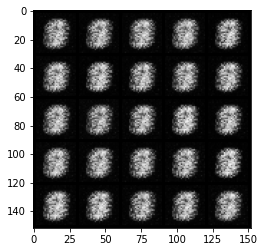

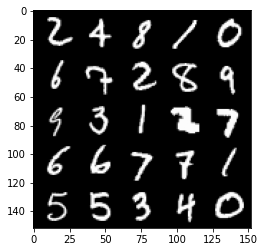

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 2.0215288311958286, discriminator loss: 0.13317049622908234


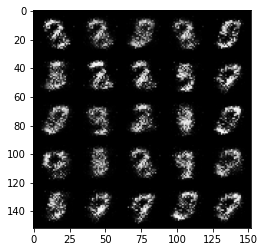

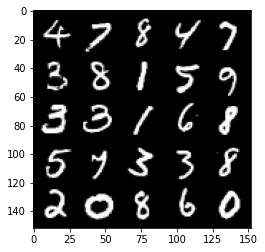

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.157185100936888, discriminator loss: 0.05298054538592713


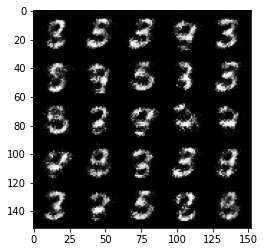

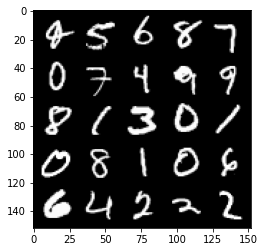

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 4.085415449237832, discriminator loss: 0.07661399962529547


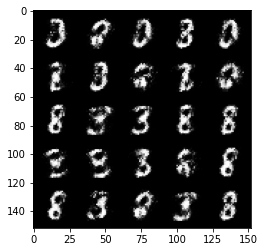

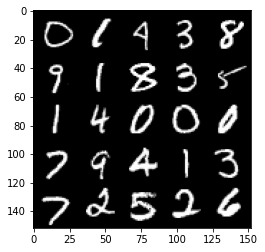

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.6762946900844584, discriminator loss: 0.11059552854597576


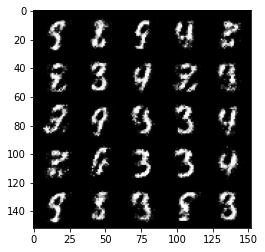

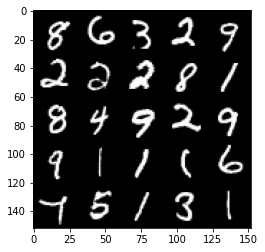

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25000: Generator loss: 3.36058745250702, discriminator loss: 0.13910276773646477


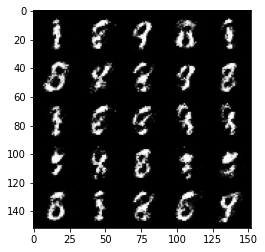

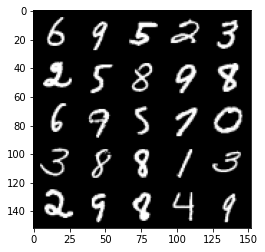

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 30000: Generator loss: 2.861051634025579, discriminator loss: 0.194194802784919


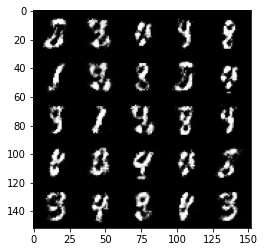

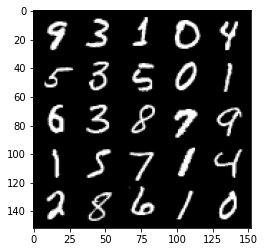

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 35000: Generator loss: 2.4250833702087453, discriminator loss: 0.24522238072454944


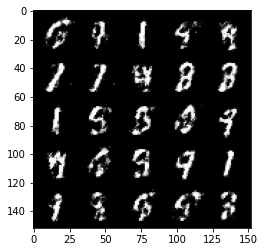

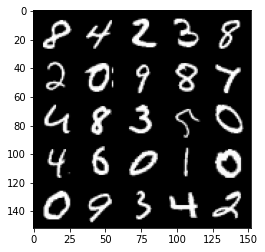

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40000: Generator loss: 2.2545657806158097, discriminator loss: 0.2741680564939965


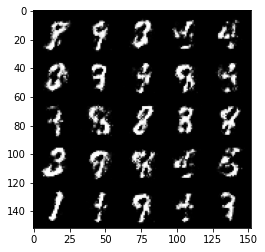

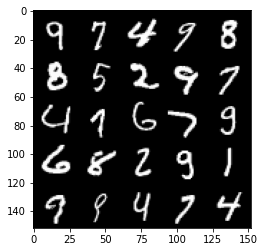

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 45000: Generator loss: 2.0352382065057792, discriminator loss: 0.304349754863977


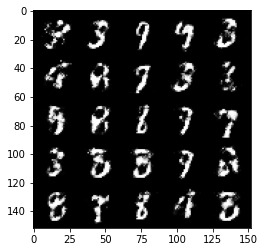

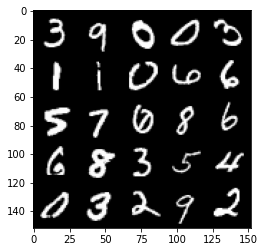

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 50000: Generator loss: 1.7977536305665938, discriminator loss: 0.35373658793568646


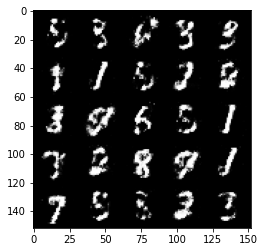

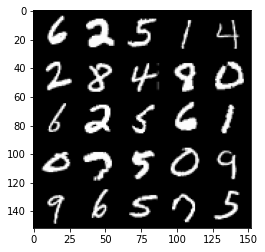

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 55000: Generator loss: 1.6272228913545597, discriminator loss: 0.38272196956277005


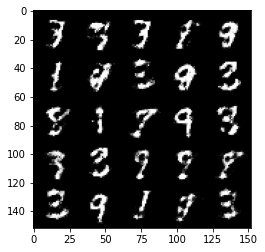

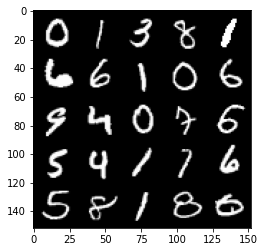

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 60000: Generator loss: 1.5780742169141782, discriminator loss: 0.39701027936041267


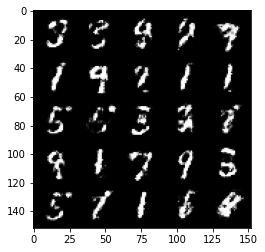

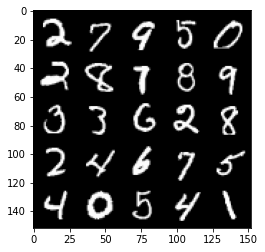

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 65000: Generator loss: 1.4368735178232197, discriminator loss: 0.43059702278375667


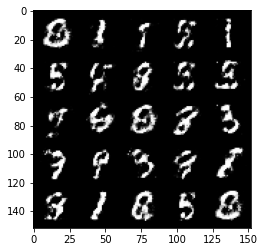

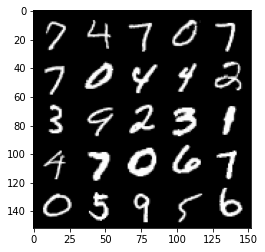

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 70000: Generator loss: 1.311136642408372, discriminator loss: 0.46645722130536926


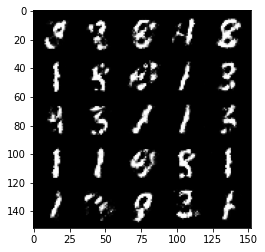

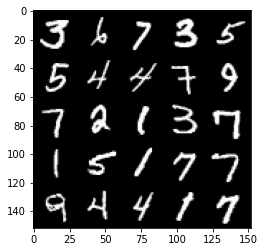

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 75000: Generator loss: 1.2721789302110684, discriminator loss: 0.4745508907556533


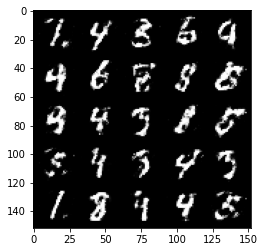

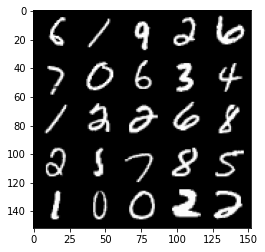

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 80000: Generator loss: 1.1505979081273081, discriminator loss: 0.5186983225047609


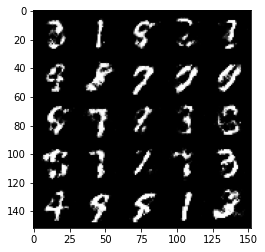

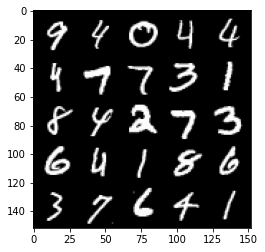

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 85000: Generator loss: 1.1548198088645942, discriminator loss: 0.5046125814080243


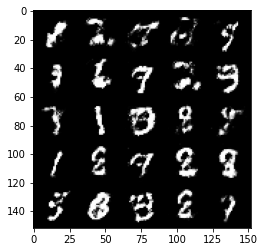

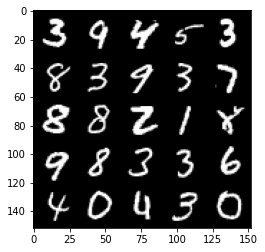

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 90000: Generator loss: 1.0747571850657436, discriminator loss: 0.5335152285754675


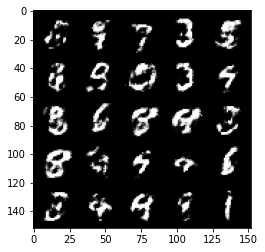

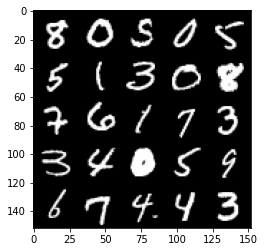

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [156]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE (~4 lines)####

        
        
        
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


